# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [254]:
import prestodb

In [255]:
conn = prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=80, user='false',
    catalog='hive',
    schema='default')

## creating a cursor object instance

In [256]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

In [4]:
#schema either in double quotes or without quotes!
cur.execute('''
SHOW TABLES from "dl_dwh_prod"
''')
records = cur.fetchall()
list(records)

[['agg_cookie_email_mapping'],
 ['agg_cookie_email_mapping_daily'],
 ['compare_isg'],
 ['fact_all_earnings'],
 ['fact_cpc_earnings'],
 ['fact_cpo_earnings'],
 ['fact_dk_earnings'],
 ['fact_leadins'],
 ['fact_leadouts'],
 ['isg'],
 ['main_sessions'],
 ['sso_registration'],
 ['sso_verification'],
 ['traces']]

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

In [276]:
cur.execute('''
WITH current_category_tree AS(
  SELECT id, parent_category_id, root_category_id, root_category_name
  FROM "dl_inventory_analytics_prod"."category_tree"
  WHERE date_parse(year||'-'||month||'-'||day, '%Y-%m-%d') = current_date - interval '1' day
  ),

  current_categories AS (
    SELECT COALESCE(element_at(context_singular_names, 'de_DE'),
           element_at(context_singular_names, 'de'),
           element_at(context_singular_names, '')) AS category_name,
    id
    FROM "dl_inventory_analytics_prod"."categories" cat
    WHERE date_parse(cat.year||'-'||cat.month||'-'||cat.day, '%Y-%m-%d') = current_date - interval '1' day
    ),

tidy_tree AS (
  SELECT roots.root_category_id,
  a.id as sub_category_id,
  b.id as sub_2_category_id,
  c.id as sub_3_category_id,
  d.id as sub_4_category_id,
  COALESCE(e.id, d.id, c.id, b.id, a.id, CAST(roots.root_category_id AS varchar)) AS bottom_category_id,
  roots.root_category_name,
  aa.category_name AS sub_category_name,
  bb.category_name AS sub_2_category_name,
  cc.category_name AS sub_3_category_name,
  dd.category_name AS sub_4_category_name,
  ee.category_name AS bottom_category_name
  FROM (SELECT DISTINCT root_category_id, root_category_name FROM current_category_tree) roots
  LEFT JOIN current_category_tree a
  ON a.parent_category_id = roots.root_category_id
  LEFT JOIN current_category_tree b
  ON CAST(b.parent_category_id AS varchar) = a.id
  LEFT JOIN current_category_tree c
  ON CAST(c.parent_category_id AS varchar) = b.id
  LEFT JOIN current_category_tree d
  ON CAST(d.parent_category_id AS varchar) = c.id
  LEFT JOIN current_category_tree e
  ON CAST(e.parent_category_id AS varchar) = d.id
  LEFT JOIN current_categories aa
  ON aa.id = a.id
  LEFT JOIN current_categories bb
  ON bb.id = b.id
  LEFT JOIN current_categories cc
  ON cc.id = c.id
  LEFT JOIN current_categories dd
  ON dd.id = d.id
  LEFT JOIN current_categories ee
  ON ee.id = COALESCE(e.id, d.id, c.id, b.id, a.id, CAST(roots.root_category_id AS varchar))),

cat_level as (
SELECT 
o.shop_id, s.shopname,
c.sub_category_name,
sum(o.pk_offers_on_oop)/count(distinct date_parse(o.year||'-'||o.month||'-'||o.day, '%Y-%m-%d')) as cat_level

FROM "dl_inventory_analytics_prod"."offer_counts" o 
join tidy_tree c on o.category_id=c.bottom_category_id
join "dl_partnershop_services_prod"."shop_base_data" s on o.shop_id=s.shop_id and 
snapshot_date=cast(current_date - interval '1' day as varchar)
where pk_offers_on_oop>0 and is_local=cast('false' as boolean) and site='de' and
date_parse(year||'-'||month||'-'||day, '%Y-%m-%d') >= current_date - interval '30' day
and c.root_category_id in (7032,12913,3686,2400,9908,3626,3932,4033,3326,30311)
group by 1,2,3),

shop_level as (
  select 
o.shop_id, 
s.shopname,
s.dk_enabled,
sum(o.pk_offers_on_oop)/count(distinct date_parse(o.year||'-'||o.month||'-'||o.day, '%Y-%m-%d')) as shop_level
FROM "dl_inventory_analytics_prod"."offer_counts" o 
join current_category_tree c on o.category_id=c.id
join "dl_partnershop_services_prod"."shop_base_data" s on o.shop_id=s.shop_id and 
snapshot_date=cast(current_date - interval '1' day as varchar)
where pk_offers_on_oop>0 and is_local=cast('false' as boolean) and site='de' and
date_parse(year||'-'||month||'-'||day, '%Y-%m-%d') >= current_date - interval '30' day
group by 1,2,3)

select distinct a.shop_id, a.shopname,a.dk_enabled,
b.sub_category_name,
b.cat_level,a.shop_level
from shop_level a left join cat_level b on a.shop_id=b.shop_id
order by 1
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  42108


In [277]:
#getting colnames from description, which is a list of columns with header and their entries
colnames = [col[0] for col in cur.description]
colnames[0:5]

['shop_id', 'shopname', 'dk_enabled', 'sub_category_name', 'cat_level']

## storing the results in a dataframe

In [278]:
import pandas as pd

In [279]:
df = pd.DataFrame(records, columns=colnames)

In [280]:
df.head(10)

,shop_id,shopname,dk_enabled,sub_category_name,cat_level,shop_level
0,1140,computeruniverse.net,True,Schmuck,1,25353
1,1140,computeruniverse.net,True,Spielekonsole,6,25353
2,1140,computeruniverse.net,True,Elektrische Zahnbürste,41,25353
3,1140,computeruniverse.net,True,Möbel,8,25353
4,1140,computeruniverse.net,True,Navigation & HiFi,78,25353
5,1140,computeruniverse.net,True,Autozubehör,1,25353
6,1140,computeruniverse.net,True,E-Scooter,17,25353
7,1140,computeruniverse.net,True,GPS & Wearables,1,25353
8,1140,computeruniverse.net,True,Auto-Werkstattausstattung,1,25353
9,1140,computeruniverse.net,True,Fotografie,1796,25353


In [281]:
df['cat_share']=df['cat_level']/df['shop_level']

In [282]:
df_1=df.pivot(index='shopname', columns='sub_category_name', values='cat_share')
#df_1['shopname'] = df_1.index

In [283]:

df_1=df_1.fillna(0)
#df_1=df_1.drop(columns=['weiteres Angebot'])
df_1.head(5)

sub_category_name,Accessoire,Anhänger & Trägersysteme,Aquaristik,Auto Tuning,Auto-Werkstattausstattung,Autopflege,Autoteil,Autozubehör,Baby-Ernährung,Babyausstattung,...,Tasche & Gepäck,Tee,Telekommunikation,Terraristik,Tiergesundheit,Uhr,Video- & Computerspiele,Vogel,Wildtier,Öle & Wartungsmittel
shopname,,,,,,,,,,,,,,,,,,,,,
0815.eu,0.000000,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.000380,...,0.000095,0.0,0.066806,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100-pro-bio.de,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101-spielwaren.de,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11teamsports.com,0.002891,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.002949,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123Babyland.de,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.292683,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
df_1.shape
#df_1=df_1.head(300)

(4967, 84)

In [23]:
df_2=df_1[(df_1['Drogerie & Gesundheit']>1.0) | (df_1['Elektroartikel']>1.0) | (df_1['Essen & Trinken']>1.0)]

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

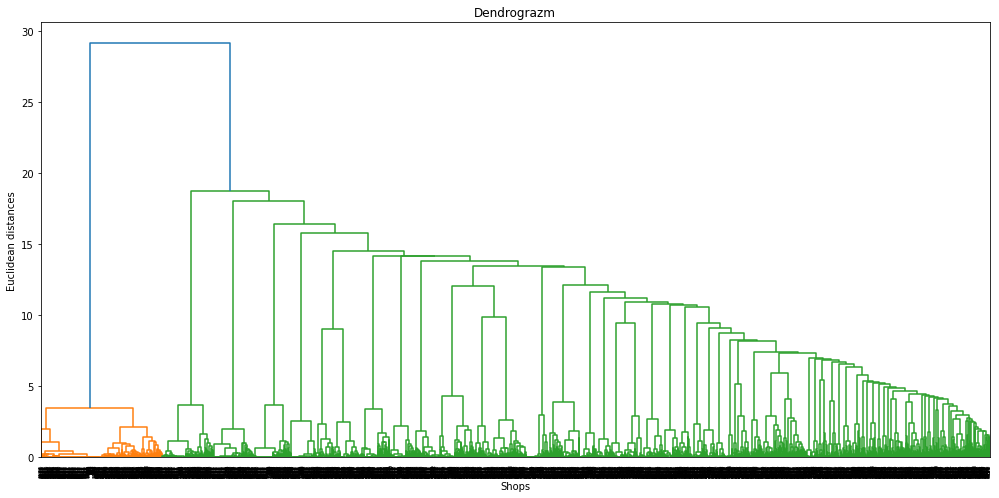

In [286]:
import seaborn as sns
df_arr=df_1.to_numpy()
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(17, 8))  
plt.title("Dendrograzm")  
plt.xlabel('Shops')
plt.ylabel('Euclidean distances')
dend = shc.dendrogram(shc.linkage(df_arr, method='ward'))
#shc.dendrogram(dend, leaf_rotation=40, leaf_font_size=8, labels=df_1.index)
#sns.clustermap(df_arr, metric="euclidean", standard_scale=1,height=2.5)
#sns_plot.savefig("output.png")

In [287]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward',compute_distances=True)  
y=cluster.fit_predict(df_1)


In [288]:
df_1['cluster']=y
df_1['shopname'] = df_1.index


In [289]:
df_1['cluster'] = df_1['cluster'].astype("category")

In [433]:
df_1.reset_index(drop=True, inplace=True)
dk=df[['shopname','dk_enabled']]
new=df_1.merge(dk, on='shopname')

In [ ]:
easycosmetic.de
galaxus.de
bueroshop24.de
aponeo.de
engelhorn.de
lidl.de
bueromarkt-ag.de

In [434]:
l1=df_1[(df_1['shopname']=='easycosmetic.de')]
l1_cluster=l1[['cluster']]

In [435]:
l1.head(5)

sub_category_name,Accessoire,Anhänger & Trägersysteme,Aquaristik,Auto Tuning,Auto-Werkstattausstattung,Autopflege,Autoteil,Autozubehör,Baby-Ernährung,Babyausstattung,...,Telekommunikation,Terraristik,Tiergesundheit,Uhr,Video- & Computerspiele,Vogel,Wildtier,Öle & Wartungsmittel,cluster,shopname
1284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,easycosmetic.de


In [436]:
l1=l1.loc[:, ~l1.columns.isin(['cluster','shopname'])]
l1=l1.to_numpy()

In [437]:
new.head(5)

,Accessoire,Anhänger & Trägersysteme,Aquaristik,Auto Tuning,Auto-Werkstattausstattung,Autopflege,Autoteil,Autozubehör,Baby-Ernährung,Babyausstattung,...,Terraristik,Tiergesundheit,Uhr,Video- & Computerspiele,Vogel,Wildtier,Öle & Wartungsmittel,cluster,shopname,dk_enabled
0,0.0,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.00038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0815.eu,False
1,0.0,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.00038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0815.eu,False
2,0.0,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.00038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0815.eu,False
3,0.0,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.00038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0815.eu,False
4,0.0,0.0,0.003132,0.0,0.000095,0.0,0.0,0.000285,0.002467,0.00038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0815.eu,False


In [ ]:
#new2=new.loc[:, ~new.columns.isin(['cluster','shopname','dk_enabled'])]

In [438]:
new['distance'] = np.linalg.norm(new.loc[:, ~new.columns.isin(['cluster','shopname','dk_enabled'])].sub(np.array(l1)), axis=1)

In [439]:
new_csv=new.merge(l1_cluster, on='cluster')
new_csv=new_csv[(new_csv['dk_enabled']==True)]
new_csv=new_csv[['shopname','distance']].drop_duplicates().sort_values(by=['distance'])

In [440]:
new_csv.head(5)

,shopname,distance
2176,aduft.de,0.006935
26130,parfum-zentrum.de,0.015906
907,Exclusiv Düfte,0.024901
26744,pieper.de,0.032752
6801,brasty.de,0.034556


In [441]:
new_csv.to_csv('similar_dk_shops_easycosmetic.csv', index=False) 

In [96]:
clus_3=new[(new['cluster']==3)& (new['dk_enabled']==True)]
clus_3.reset_index(drop=True, inplace=True)

In [97]:
clus_3.head()

,Auto & Motorrad,Baby & Kind,Drogerie & Gesundheit,Elektroartikel,Essen & Trinken,Gaming & Spielen,Haus & Garten,Mode & Accessoire,Sport & Outdoor,Tierbedarf,cluster,shopname,dk_enabled
0,0.000000,0.07119,0.006674,0.000000,0.0,0.024472,0.895439,0.0,0.000000,0.0,3,123moebel.de,True
1,0.000000,0.07119,0.006674,0.000000,0.0,0.024472,0.895439,0.0,0.000000,0.0,3,123moebel.de,True
2,0.000000,0.07119,0.006674,0.000000,0.0,0.024472,0.895439,0.0,0.000000,0.0,3,123moebel.de,True
3,0.000000,0.07119,0.006674,0.000000,0.0,0.024472,0.895439,0.0,0.000000,0.0,3,123moebel.de,True
4,0.001077,0.00000,0.024767,0.049533,0.0,0.001795,0.917803,0.0,0.004307,0.0,3,1a-neuware.de,True


In [93]:
clus_3.drop_duplicates() 

,Auto & Motorrad,Baby & Kind,Drogerie & Gesundheit,Elektroartikel,Essen & Trinken,Gaming & Spielen,Haus & Garten,Mode & Accessoire,Sport & Outdoor,Tierbedarf,cluster,shopname,dk_enabled
0,0.000000,0.071190,0.006674,0.000000,0.000000,0.024472,0.895439,0.000000,0.000000,0.000000,3,123moebel.de,True
4,0.001077,0.000000,0.024767,0.049533,0.000000,0.001795,0.917803,0.000000,0.004307,0.000000,3,1a-neuware.de,True
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3,1a-pumpen.de,True
11,0.001994,0.000109,0.002502,0.162963,0.000181,0.000036,0.829315,0.000000,0.002755,0.000036,3,AFB eSolutions,True
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3,Beliani.de,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,0.000000,0.000000,0.006594,0.000101,0.000000,0.000000,0.993304,0.000000,0.000000,0.000000,3,xtwostore.de,True
1353,0.000000,0.000000,0.000000,0.034232,0.000000,0.000000,0.965768,0.000000,0.000000,0.000000,3,zaehlerschrank24.de,True
1355,0.000000,0.000000,0.052951,0.031440,0.000000,0.000552,0.876999,0.007722,0.013238,0.015444,3,zeitzone.de,True
1362,0.000000,0.020085,0.000000,0.003043,0.000000,0.000000,0.879489,0.096774,0.000000,0.000000,3,zeo-living.de,True


In [98]:
clus_3.shape

(1373, 13)

In [65]:

clus_0=new[(new['cluster']==0) & (new['dk_enabled']==True)]
clus_1=new[(new['cluster']==1)& (new['dk_enabled']==True)]
clus_2=new[(new['cluster']==2)& (new['dk_enabled']==True)]
clus_5=new[(new['cluster']==5)& (new['dk_enabled']==True)]

In [86]:
clus_3.head(5)

,Auto & Motorrad,Baby & Kind,Drogerie & Gesundheit,Elektroartikel,Essen & Trinken,Gaming & Spielen,Haus & Garten,Mode & Accessoire,Sport & Outdoor,Tierbedarf
44,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
235,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
446,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
707,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [90]:
clus_3.to_csv('clus_3.csv', index=False)  

<ipython-input-99-d302ba083022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clus_3['shopname'] = clus_3.index


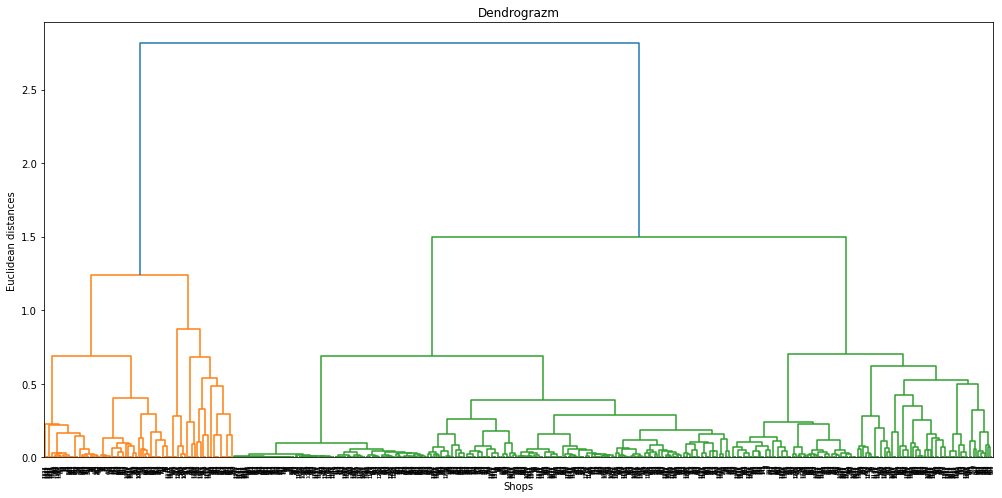

In [99]:
clus_3['shopname'] = clus_3.index
clus_3=clus_3.drop(columns=['dk_enabled', 'cluster','shopname'])
clus_3_arr=clus_3.to_numpy()
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(17, 8))  
plt.title("Dendrograzm")  
plt.xlabel('Shops')
plt.ylabel('Euclidean distances')
dend = shc.dendrogram(shc.linkage(clus_3_arr, method='ward'))
plt.show()

In [ ]:
cluster

In [222]:
new.to_csv('similar_dk_shops.csv', index=False)  

In [25]:
df_2=df_1[(df_1['Drogerie & Gesundheit']>1.0) | (df_1['Elektroartikel']>1.0) | (df_1['Essen & Trinken']>1.0)]

In [27]:
df_2.shape

(4, 12)

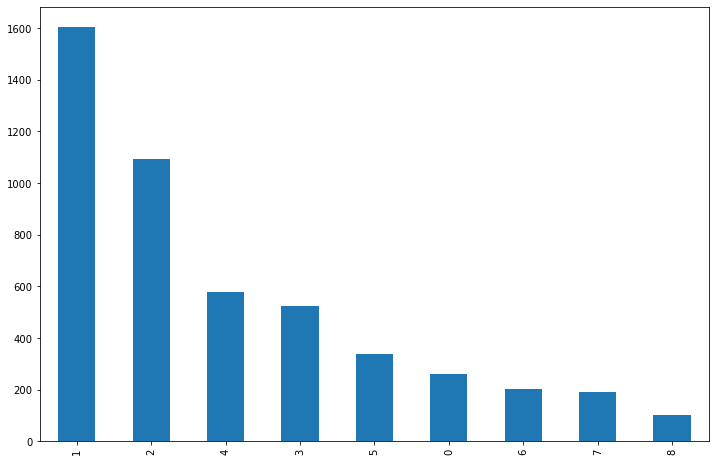

In [29]:
fig=(df_1.loc[:,'cluster']
 .value_counts()
 .plot(kind='bar', figsize=[12,8]))
#sht.pictures.add(fig, name='MyPlot', update=True)

<Picture 'MyPlot' in <Sheet [Book2]Sheet1>>

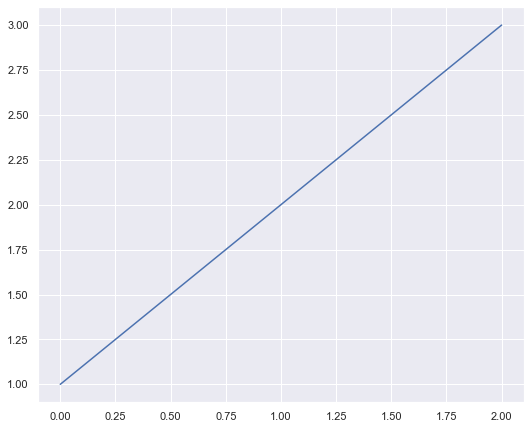

In [34]:
import xlwings as xw
#to write on Excel
xw.Range('B1').value = df_1
#Save image to Excel
fig = plt.figure()
plt.plot([1, 2, 3])
sht = xw.Book().sheets[0]
sht.pictures.add(fig, name='MyPlot', update=True)

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Elektroartikel'],hue=df_1['cluster'])
sht.pictures.add(sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Elektroartikel'],hue=df_1['cluster']), name='MyPlot', update=True)

<AxesSubplot:xlabel='shopname', ylabel='Drogerie & Gesundheit'>

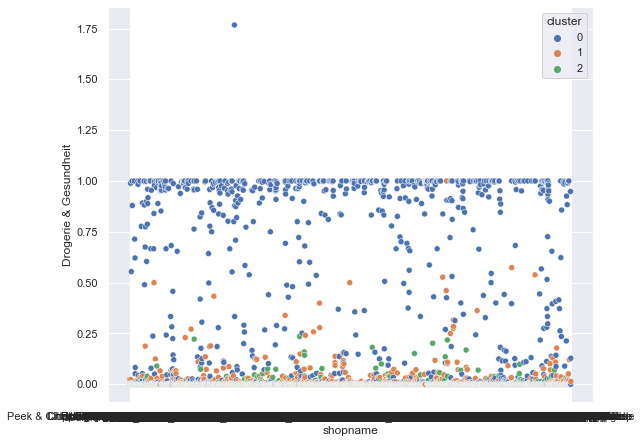

In [38]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Drogerie & Gesundheit'],hue=df_1['cluster'])

<AxesSubplot:xlabel='shopname', ylabel='Baby & Kind'>

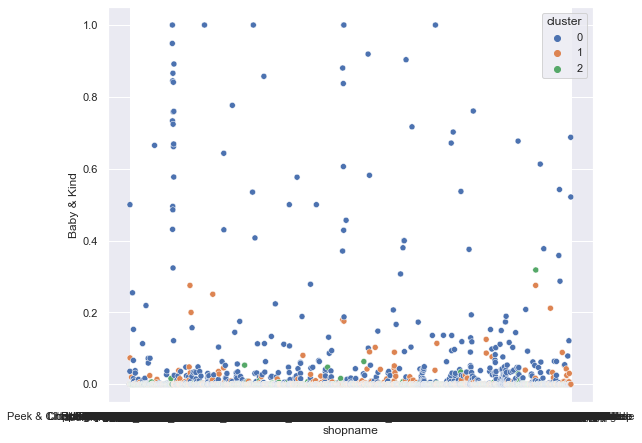

In [39]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Baby & Kind'],hue=df_1['cluster'])

<AxesSubplot:xlabel='shopname', ylabel='Gaming & Spielen'>

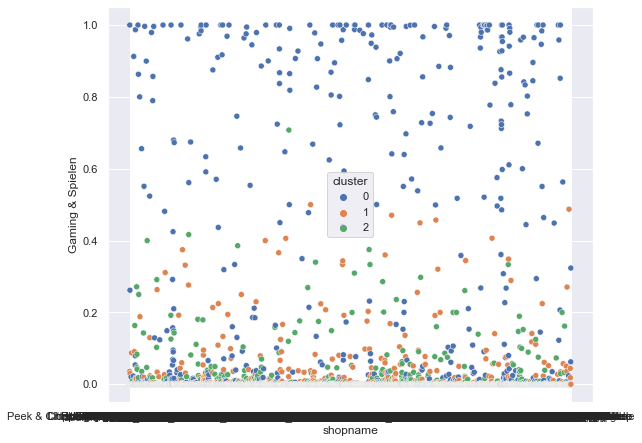

In [40]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Gaming & Spielen'],hue=df_1['cluster'])

<AxesSubplot:xlabel='shopname', ylabel='Haus & Garten'>

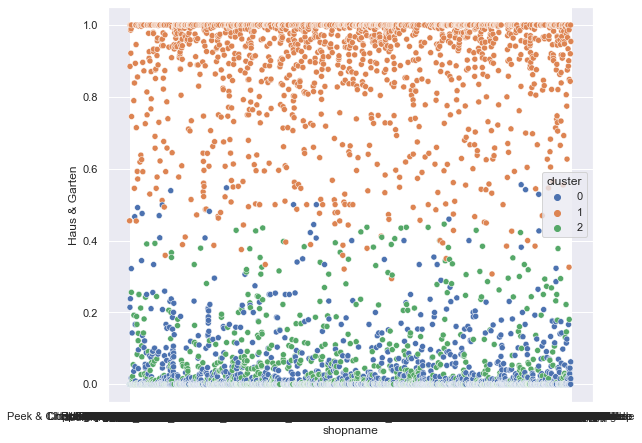

In [41]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Haus & Garten'],hue=df_1['cluster'])

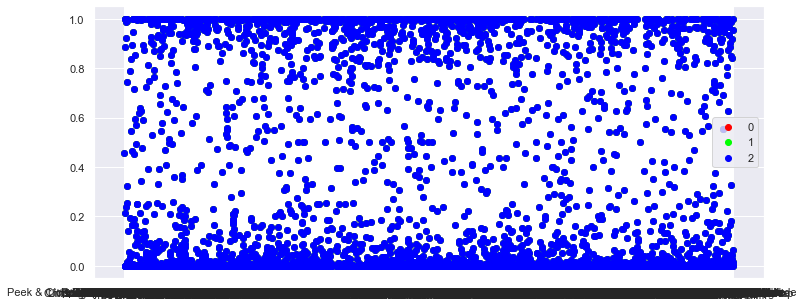

In [51]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors=["#f00","#0f0","#00f"]
#colors=cm.get_cmap('viridis', 8);

plt.rcParams["figure.figsize"]=12,5
for k,d in df_1.groupby('cluster'):
    #d = result_joined
    #plt.scatter(d['month'], d['pageimpressions_share'], c=d['cluster'], cmap='hsv', label=k)
    plt.scatter(df_1['shopname'], df_1['Haus & Garten'], c=colors[k], cmap='hsv', label=k)
plt.legend()

<AxesSubplot:xlabel='shopname', ylabel='Auto & Motorrad'>

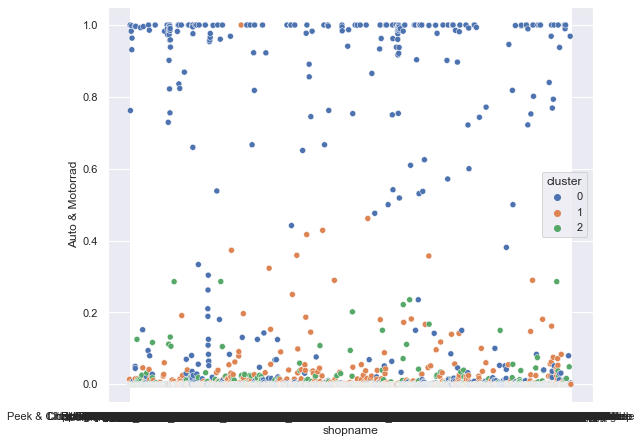

In [42]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Auto & Motorrad'],hue=df_1['cluster'])

<AxesSubplot:xlabel='shopname', ylabel='Essen & Trinken'>

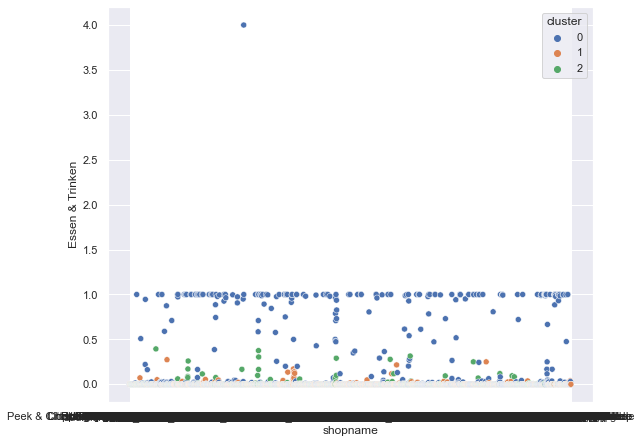

In [43]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Essen & Trinken'],hue=df_1['cluster'])

<AxesSubplot:xlabel='shopname', ylabel='Mode & Accessoire'>

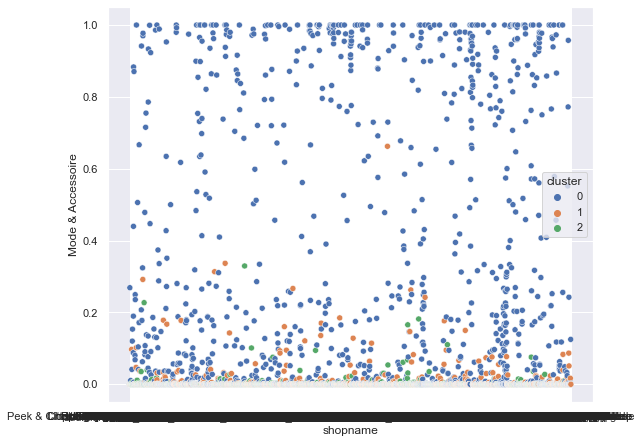

In [44]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Mode & Accessoire'],hue=df_1['cluster'])


<AxesSubplot:xlabel='shopname', ylabel='Sport & Outdoor'>

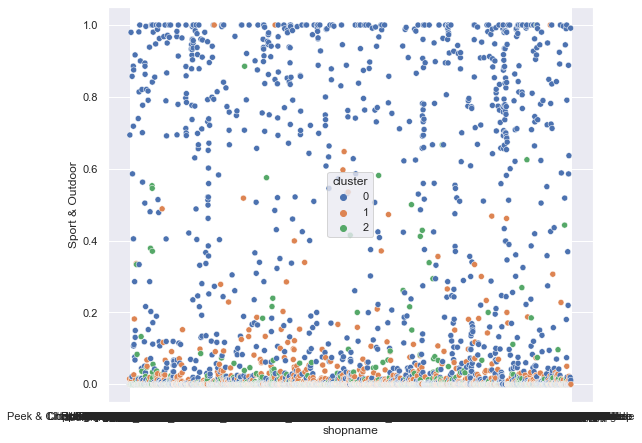

In [45]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Sport & Outdoor'],hue=df_1['cluster'])


<AxesSubplot:xlabel='shopname', ylabel='Tierbedarf'>

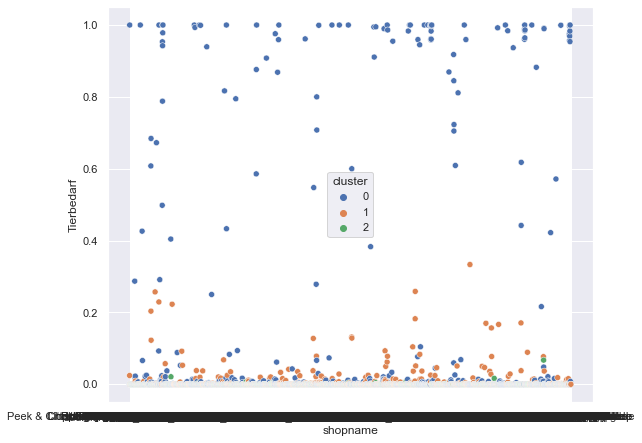

In [46]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,7.27)})
sns.scatterplot(data=df_1, x=df_1['shopname'], y=df_1['Tierbedarf'],hue=df_1['cluster'])


In [13]:
# this this function, you can override pandas default number of columns or rows
def disp_full(df, rows=100, cols=None, colwidth=100):
    with pd.option_context('display.max_rows', rows, 'display.max_columns', cols, 'max_colwidth', colwidth):
        display(df)

disp_full(df.transpose(), rows=234, cols=5) #max is now 234 rows which is the number of rows our transposed df has

,0,1,...,998,999
revisit_creationtime,None,None,...,None,None
session_time,2020-07-05,2020-07-05,...,2020-07-01,2020-07-01
main_creationtime,None,None,...,None,None
isession_creationtime,None,None,...,None,None
tracetime,None,None,...,None,None
country,de,de,...,es,es
trafficsource,sem,sem,...,utm,sem
seo_query_idealo,None,None,...,None,None
channel,www,www,...,app,www
landing_pagetemplate,MainSearchProductCategory,ProductCategory,...,OffersOfProduct,None


In [14]:
df.channel.value_counts()

www    839
app    161
Name: channel, dtype: int64

In [15]:
df.session_time.value_counts()

2020-06-28    197
2020-06-16    133
2020-07-13    129
2020-06-23    108
2020-06-25    107
2020-06-20    102
2020-06-26     89
2020-07-01     65
2020-07-05     51
2020-06-19     19
Name: session_time, dtype: int64

In [16]:
def find_column(search='page', colnames=colnames):
    return [col for col in colnames if search in col]

looking at page_templates

In [17]:
find_column('page_')

['page_template']

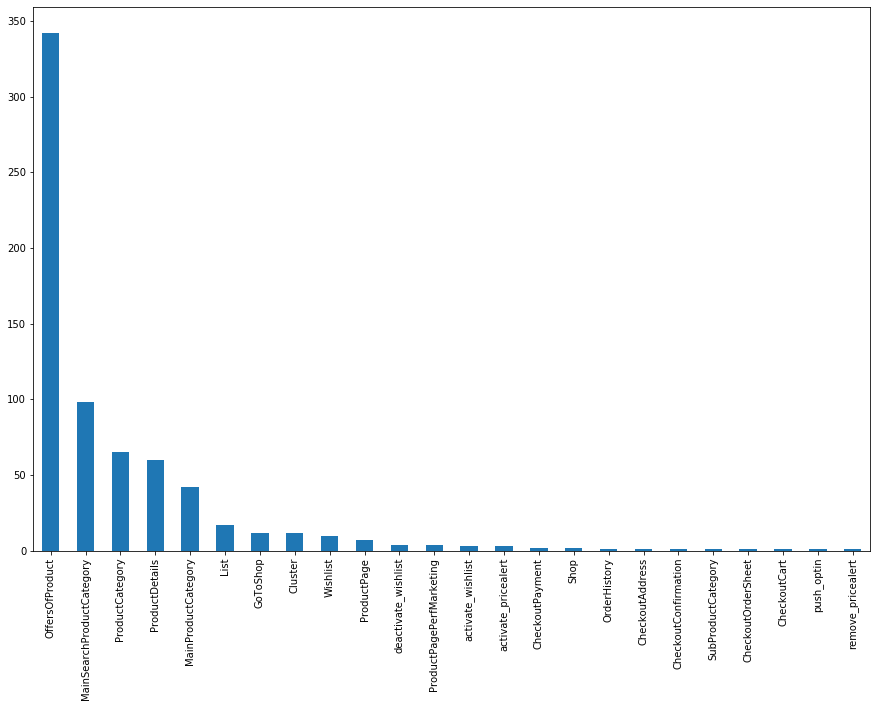

In [18]:
(df.loc[:,'page_template']
 .value_counts()
 .plot(kind='bar', figsize=[15,10]))

a time series

In [19]:
find_column('lead')

['leadin_source',
 'leadout_click_bokey',
 'offers_leadout_available',
 'leadout_shop_id',
 'leadout_merchant_id',
 'leadout_type',
 'leadout_provider',
 'leadout_price',
 'leadout_cosponsoring_amount',
 'leadout_repricing_amount',
 'leadout_strike_price',
 'leadout_price_group',
 'leadout_click_position',
 'leadout_affiliate',
 'leadout_partner_rank',
 'leadout_tracking_id',
 'leadout_checkout_available',
 'leadout_delivery_speed',
 'total_leadouts',
 'total_leadouts_oop',
 'total_loggedin_leadouts',
 'total_reloadblocked_leadouts',
 'leadouts',
 'reloadblocked_leadouts',
 'loggedin_leadouts']

In [20]:
df.session_time.value_counts()

2020-06-28    197
2020-06-16    133
2020-07-13    129
2020-06-23    108
2020-06-25    107
2020-06-20    102
2020-06-26     89
2020-07-01     65
2020-07-05     51
2020-06-19     19
Name: session_time, dtype: int64

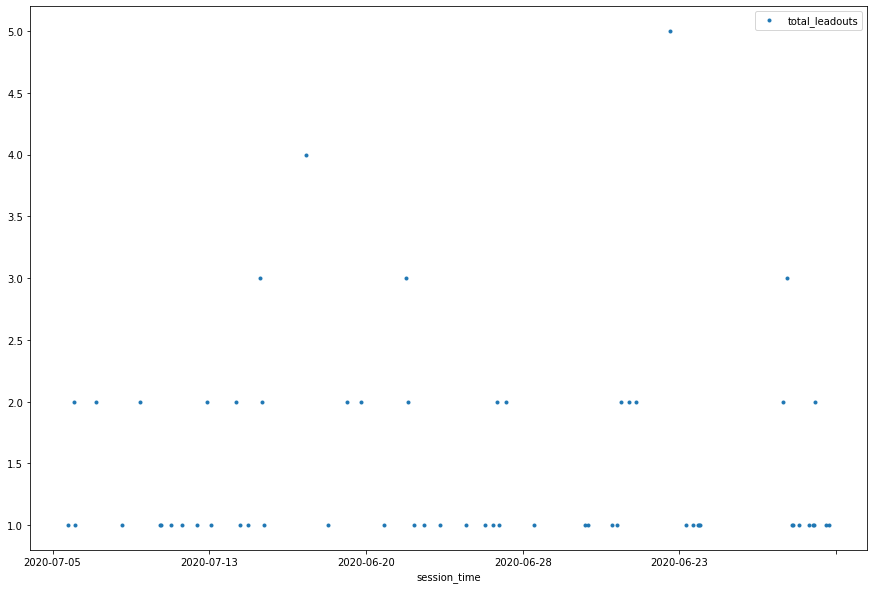

In [21]:
(df.loc[:,['session_time', 'total_leadouts']]
 #.fillna(0)
 .set_index('session_time')
 .plot(kind='line',
       marker='.',
       linestyle='none',
       figsize=[15,10]))

#  tools

## sql to df

In [5]:
conn = prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=80, user='false',
    catalog='hive',
    schema='default')

def sql_to_df(connection, query):
    cursor = conn.cursor()
    cursor.execute(query)
    records = cursor.fetchall()
    colnames = [col[0] for col in cursor.description]
    return pd.DataFrame(records, columns=colnames)

NameError: name 'prestodb' is not defined

In [23]:
df = sql_to_df(connection=conn,
               query='''
select *
from "dl_dwh_prod"."isg"
limit 100

''')

In [24]:
display(df.shape, df.columns, df.head())

(100, 145)

Index(['trace_time', 'trace_uuid', 'isession_id', 'isession_creationtime',
       'botstatus', 'landing_page', 'landing_category_id',
       'landing_category_path_ids', 'revisit_session_id',
       'revisit_creationtime',
       ...
       'tracker_site', 'utm_campaign', 'utm_content', 'utm_medium',
       'utm_source', 'utm_term', 'url_email_hash', 'session_entry', 'date_utc',
       'hour'],
      dtype='object', length=145)

,trace_time,trace_uuid,isession_id,isession_creationtime,botstatus,landing_page,landing_category_id,landing_category_path_ids,revisit_session_id,revisit_creationtime,...,tracker_site,utm_campaign,utm_content,utm_medium,utm_source,utm_term,url_email_hash,session_entry,date_utc,hour
0,1594693379968,e2e165fa-5d23-4bbc-bc8e-e8a698dd66e5,3728547779063179136,1594693379968,user,unknown,None,None,3728547779063179136,1594693379968,...,WL_FR,None,None,None,None,None,None,1,2020-07-14,2
1,1594693381058,bec65e3b-afdf-4e18-b135-bd93bd069c2d,1371679733739278638,1594693374254,bot_suspect_many_sessions,MainSearchProductCategory,19083,"[3686, 6812, 15012, 19083]",1371679733739265043,1594693360659,...,W_UK,None,None,None,None,None,None,0,2020-07-14,2
2,1594693381133,a4423d86-eec7-40b4-865b-03e982708177,1233058805267426031,1594693380847,bot_suspect_many_sessions,MainSearchProductCategory,3250,"[3686, 18442, 3250]",1233058805267410380,1594693365196,...,W_UK,None,None,None,None,None,None,0,2020-07-14,2
3,1594693381514,de7df0ad-b1c9-4880-a98a-e330414cf88f,7278779565686779274,1594693381514,unknown,unknown,,,7278779565686779274,1594693381514,...,W_DE,None,None,None,None,None,None,1,2020-07-14,2
4,1594693381945,0b3742d8-3d83-4f6b-a857-68e16c7cc1f8,1720330472860529178,1594693366298,user,MainSearchProductCategory,13232,"[3686, 6812, 15012, 13232]",1720330472860529178,1594693366298,...,W_AT,None,None,None,None,None,None,0,2020-07-14,2
